In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split,Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split

## Preparing Data

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
transform=transforms.Compose([transforms.ToTensor()])

In [4]:
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
mnist_test = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

In [5]:
data =mnist_train.data.numpy().astype(np.float32)/255.0
labels=mnist_train.targets.numpy()

In [6]:
data=data.reshape(data.shape[0],-1) 

In [7]:
data_train,data_temp,labels_train,labels_temp=train_test_split(data,labels,test_size=0.4,random_state=42,stratify=labels)
data_val,data_test,labels_val,labels_test=train_test_split(data_temp,labels_temp,test_size=0.5,random_state=42,stratify=labels_temp)

In [8]:
print("train:",data_train.shape,labels_train.shape)
print("val:",data_val.shape,labels_val.shape)
print("test:",data_test.shape,labels_test.shape)

train: (36000, 784) (36000,)
val: (12000, 784) (12000,)
test: (12000, 784) (12000,)


In [9]:
data_train_tensor=torch.tensor(data_train)
labels_train_tensor=torch.tensor(labels_train,dtype=torch.long)

data_val_tensor=torch.tensor(data_val)
labels_val_tensor=torch.tensor(labels_val,dtype=torch.long)

data_test_tensor=torch.tensor(data_test)
labels_test_tensor=torch.tensor(labels_test,dtype=torch.long)

In [10]:
trainig_dataset=TensorDataset(data_train_tensor,labels_train_tensor)
validation_dataset=TensorDataset(data_val_tensor,labels_val_tensor)
testing_dataset=TensorDataset(data_test_tensor,labels_test_tensor)

In [11]:
training_loader=DataLoader(trainig_dataset,batch_size=64,shuffle=True)
validation_loader=DataLoader(validation_dataset,batch_size=64,shuffle=False)
testing_loader=DataLoader(testing_dataset,batch_size=64,shuffle=False)

# A2 . Logistic Regression 

###  Binary Classification Task


In [12]:
zero_one_training=(labels_train_tensor==0)|(labels_train_tensor==1)
zero_one_validation=(labels_val_tensor==0)|(labels_val_tensor==1)


In [13]:
data_trianing_binary=data_train_tensor[zero_one_training]
labels_training_binary=labels_train_tensor[zero_one_training].unsqueeze(1)

In [14]:
data_validation_binary=data_val_tensor[zero_one_validation]
labels_validation_binary=labels_val_tensor[zero_one_validation].unsqueeze(1)

In [15]:
number_of_features=data_trianing_binary.shape[1] #number of input pixels
W=torch.zeros((number_of_features,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

lr=0.01
num_epochs=1000 #how many times to iterate over the training set

In [16]:
def segmoid(z):
    return 1/(1+torch.exp(-z))

In [17]:
def linear_output(X,W,b):
    return torch.matmul(X,W) +b

In [18]:
training_losses=[]
validation_losses=[]
training_accuracies=[]
validation_accuracies=[]

In [19]:
for epoch in range(num_epochs):
    #Forward pass
    linear_out=linear_output(data_trianing_binary,W,b)
    labels_predection=segmoid(linear_out)
    
    #Compute loss
    training_loss = -torch.mean(labels_training_binary*torch.log(labels_predection)+(1-labels_training_binary)*torch.log(1-labels_predection)) 
    
    #training accuracy
    labels_training_predection=(labels_predection>=0.5).float()
    training_accuracy=torch.mean((labels_training_predection==labels_training_binary).float())

    # validattion pass
    with torch.no_grad():
        linear_out_val=linear_output(data_validation_binary,W,b)
        labels_predection_val=segmoid(linear_out_val)
        
        #Compute validation loss
        validation_loss = -torch.mean(labels_validation_binary*torch.log(labels_predection_val)+(1-labels_validation_binary)*torch.log(1-labels_predection_val)) 
        
        #validation accuracy
        labels_validation_predection=(labels_predection_val>=0.5).float()
        validation_accuracy=torch.mean((labels_validation_predection==labels_validation_binary).float())
    #Backward pass on training loss
    training_loss.backward()
    #Update weights
    with torch.no_grad():
        W-=lr*W.grad
        b-=lr*b.grad

    # Reset gradients
    W.grad.zero_()
    b.grad.zero_()
    
    # Store losses and accuracies
    training_losses.append(training_loss.item())
    validation_losses.append(validation_loss.item())
    training_accuracies.append(training_accuracy.item())
    validation_accuracies.append(validation_accuracy.item())
    if (epoch+1)%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss.item():.4f}')

Epoch [100/1000], Loss: 0.1201
Epoch [200/1000], Loss: 0.0701
Epoch [300/1000], Loss: 0.0515
Epoch [400/1000], Loss: 0.0416
Epoch [500/1000], Loss: 0.0354
Epoch [600/1000], Loss: 0.0311
Epoch [700/1000], Loss: 0.0280
Epoch [800/1000], Loss: 0.0255
Epoch [900/1000], Loss: 0.0236
Epoch [1000/1000], Loss: 0.0220


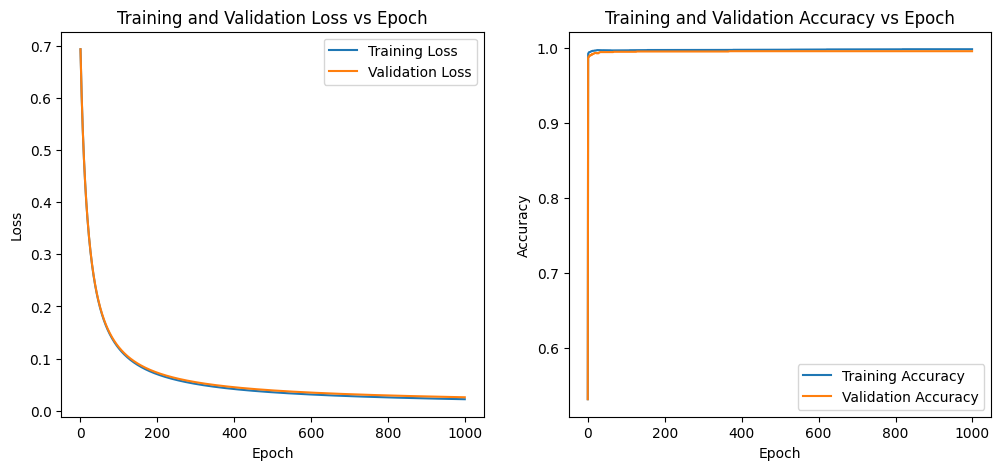

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(training_accuracies,label='Training Accuracy')
plt.plot(validation_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.show()

### Final Test Accuracy

In [21]:
with torch.no_grad():
    zero_one_testing=(labels_test_tensor==0)|(labels_test_tensor==1)
    data_testing_binary=data_test_tensor[zero_one_testing]
    labels_testing_binary=labels_test_tensor[zero_one_testing].unsqueeze(1)

    linear_out_test=linear_output(data_testing_binary,W,b)
    labels_predection_test=segmoid(linear_out_test)

    labels_testing_predection_class=(labels_predection_test>=0.5).float() 
    test_accuracy=torch.mean((labels_testing_predection_class==labels_testing_binary).float())

print(f'Test Accuracy: {test_accuracy.item()*100:.2f}%')

Test Accuracy: 99.84%


### Confusion Matrix

In [22]:
confusion_matrix=torch.zeros(2,2,dtype=torch.int32)
with torch.no_grad():
    for true_label, pred_label in zip(labels_testing_binary, labels_testing_predection_class):
        confusion_matrix[int(true_label.item()), int(pred_label.item())] += 1


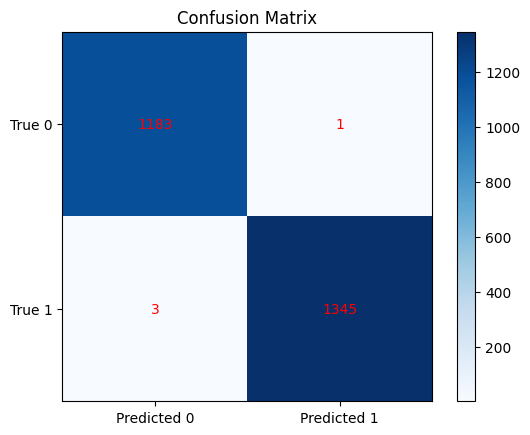

In [23]:
plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], labels=['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], labels=['True 0', 'True 1'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i, j].item(), ha='center', va='center', color='red')

plt.show()

# A3.Softmax Regression

### Multi-class Classification Task

In [24]:
def softmax(z):
    exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True).values)
    return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

In [25]:
def cross_entropy_loss(predictions, targets):
    num_samples = predictions.shape[0]
    log_probs = -torch.log(predictions[range(num_samples), targets])
    loss = torch.mean(log_probs)
    return loss

In [26]:
number_of_features=28*28 
number_of_classes=10

W_multi=torch.zeros((number_of_features,number_of_classes),requires_grad=True)
b_multi=torch.zeros((1,number_of_classes),requires_grad=True)

lr=0.01
num_epochs=10

In [27]:
training_losses=[]
validation_losses=[]
training_accuracies=[]
validation_accuracies=[]

In [28]:

for epoch in range(num_epochs):
    total_loss=0
    total_correct=0
    total=0
    for images,labels in training_loader:
        trained_data=images.view(-1,28*28)

        scores=linear_output(trained_data,W_multi,b_multi)
        training_predictions=softmax(scores)

        loss=cross_entropy_loss(training_predictions,labels)
        loss.backward()

        predections=torch.argmax(training_predictions,dim=1)

        total_correct+=(predections==labels).sum().item()
        total+=labels.size(0)
        total_loss+=loss.item()*labels.size(0)

        with torch.no_grad():
            W_multi-=lr*W_multi.grad
            b_multi-=lr*b_multi.grad
        W_multi.grad.zero_()
        b_multi.grad.zero_()


    training_loss=total_loss/total
    training_accuracy=total_correct/total
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)


    with torch.no_grad():
        total_val_loss=0
        total_val_correct=0
        total_val=0
        for val_images,val_labels in validation_loader:
            val_trained_data=val_images.view(-1,28*28)

            val_scores=linear_output(val_trained_data,W_multi,b_multi)
            val_predictions=softmax(val_scores)

            val_loss=cross_entropy_loss(val_predictions,val_labels)

            val_predections=torch.argmax(val_predictions,dim=1)

            total_val_correct+=(val_predections==val_labels).sum().item()
            total_val+=val_labels.size(0)
            total_val_loss+=val_loss.item()*val_labels.size(0)

        validation_loss=total_val_loss/total_val
        validation_accuracy=total_val_correct/total_val
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')

Epoch [1/10], Training Loss: 1.1714, Validation Loss: 0.7672
Epoch [2/10], Training Loss: 0.6552, Validation Loss: 0.5943
Epoch [3/10], Training Loss: 0.5443, Validation Loss: 0.5240
Epoch [4/10], Training Loss: 0.4908, Validation Loss: 0.4849
Epoch [5/10], Training Loss: 0.4581, Validation Loss: 0.4587
Epoch [6/10], Training Loss: 0.4353, Validation Loss: 0.4405
Epoch [7/10], Training Loss: 0.4185, Validation Loss: 0.4260
Epoch [8/10], Training Loss: 0.4052, Validation Loss: 0.4143
Epoch [9/10], Training Loss: 0.3944, Validation Loss: 0.4054
Epoch [10/10], Training Loss: 0.3856, Validation Loss: 0.3973


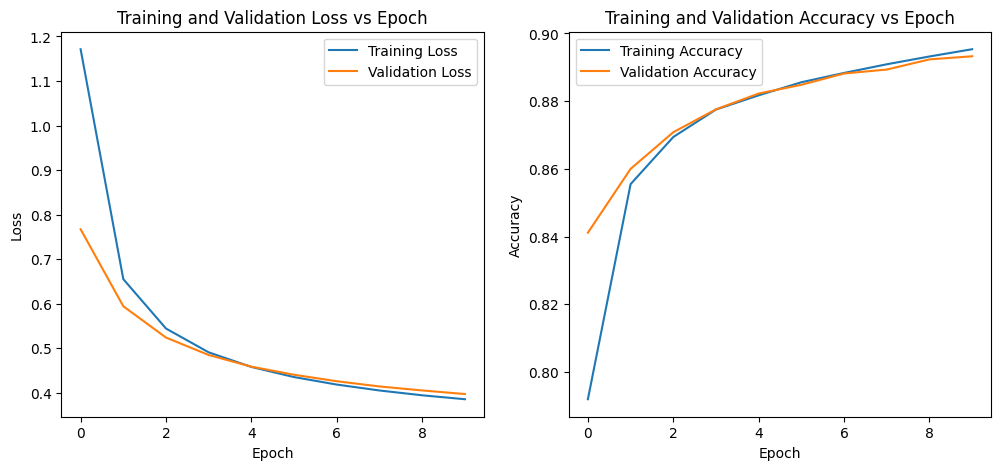

In [29]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(training_accuracies,label='Training Accuracy')
plt.plot(validation_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.show()

In [30]:
confusion_matrix_multi=torch.zeros(number_of_classes,number_of_classes,dtype=torch.int32)
total_correct=0
total=0
with torch.no_grad():
    for test_images,test_labels in testing_loader:
        test_trained_data=test_images.view(-1,28*28)

        test_scores=linear_output(test_trained_data,W_multi,b_multi)
        test_predictions=softmax(test_scores)

        test_predections=torch.argmax(test_predictions,dim=1)

        total_correct+=(test_predections==test_labels).sum().item()
        total+=test_labels.size(0)

        for true_label, pred_label in zip(test_labels, test_predections):
            confusion_matrix_multi[int(true_label.item()), int(pred_label.item())] += 1
test_accuracy=total_correct/total
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Test Accuracy: 89.34%


In [31]:
print(confusion_matrix_multi)

tensor([[1129,    0,    8,    5,    5,   14,    9,    1,   13,    0],
        [   0, 1300,    5,    7,    0,    9,    3,    5,   16,    3],
        [  14,   21, 1025,   20,   21,    2,   29,   20,   32,    8],
        [   9,    6,   35, 1067,    0,   53,    6,   11,   28,   12],
        [   4,    8,   10,    2, 1050,    0,   17,    2,    8,   68],
        [  26,   16,    8,   54,   14,  879,   21,    7,   36,   23],
        [  13,    4,   18,    1,   12,   19, 1103,    0,   12,    1],
        [   7,   26,   25,    4,    7,    3,    1, 1125,    3,   52],
        [   8,   39,   14,   44,    3,   34,    8,    6,  992,   22],
        [   1,    7,    5,   15,   51,    8,    1,   37,   14, 1051]],
       dtype=torch.int32)


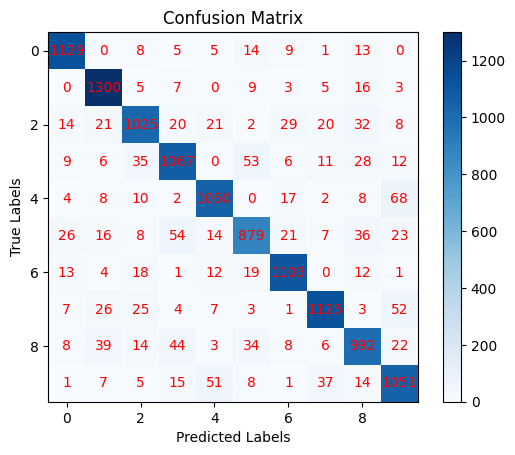

In [32]:
plt.imshow(confusion_matrix_multi, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

for i in range(number_of_classes):
    for j in range(number_of_classes):
        plt.text(j, i, confusion_matrix_multi[i, j].item(), ha='center', va='center', color='red')

plt.show()

In [33]:
accuracy_per_class=confusion_matrix_multi.diagonal()/confusion_matrix_multi.sum(dim=1)
for i, accuracy in enumerate(accuracy_per_class):
    print(f'Accuracy for class {i}: {accuracy.item()*100:.2f}%')


Accuracy for class 0: 95.35%
Accuracy for class 1: 96.44%
Accuracy for class 2: 85.99%
Accuracy for class 3: 86.96%
Accuracy for class 4: 89.82%
Accuracy for class 5: 81.09%
Accuracy for class 6: 93.24%
Accuracy for class 7: 89.78%
Accuracy for class 8: 84.79%
Accuracy for class 9: 88.32%


## Neural Network

In [34]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size=784, hidden1=256, hidden2=128, output_size=10):
        super(FeedforwardNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_size)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [35]:
model = FeedforwardNN(input_size=784, hidden1=256, hidden2=128, output_size=10).to(torch.device("cpu"))

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [36]:
def calculate_accuracy(model, dataloader):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(torch.device("cpu")), labels.to(torch.device("cpu"))
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [37]:
num_epochs = 50  
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    for inputs, labels in training_loader:
        inputs, labels = inputs.to(torch.device("cpu")), labels.to(torch.device("cpu"))
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_loss / len(training_loader.dataset)
    
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(torch.device("cpu")), labels.to(torch.device("cpu"))
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
    
    epoch_val_loss = val_running_loss / len(validation_loader.dataset)
    
    train_acc = calculate_accuracy(model, training_loader)
    val_acc = calculate_accuracy(model, validation_loader)
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


Epoch [1/50] Train Loss: 1.0685, Val Loss: 0.5194, Train Acc: 86.98%, Val Acc: 86.58%
Epoch [2/50] Train Loss: 0.4250, Val Loss: 0.3836, Train Acc: 89.68%, Val Acc: 89.42%
Epoch [3/50] Train Loss: 0.3436, Val Loss: 0.3362, Train Acc: 90.91%, Val Acc: 90.74%
Epoch [4/50] Train Loss: 0.3043, Val Loss: 0.3054, Train Acc: 91.79%, Val Acc: 91.62%
Epoch [5/50] Train Loss: 0.2781, Val Loss: 0.2819, Train Acc: 92.47%, Val Acc: 92.05%
Epoch [6/50] Train Loss: 0.2585, Val Loss: 0.2657, Train Acc: 92.98%, Val Acc: 92.54%
Epoch [7/50] Train Loss: 0.2418, Val Loss: 0.2515, Train Acc: 93.44%, Val Acc: 93.03%
Epoch [8/50] Train Loss: 0.2269, Val Loss: 0.2383, Train Acc: 93.81%, Val Acc: 93.17%
Epoch [9/50] Train Loss: 0.2150, Val Loss: 0.2276, Train Acc: 94.19%, Val Acc: 93.44%
Epoch [10/50] Train Loss: 0.2039, Val Loss: 0.2201, Train Acc: 94.50%, Val Acc: 93.59%
Epoch [11/50] Train Loss: 0.1938, Val Loss: 0.2116, Train Acc: 94.74%, Val Acc: 93.89%
Epoch [12/50] Train Loss: 0.1846, Val Loss: 0.2020, 

In [38]:
test_acc = calculate_accuracy(model, testing_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")


Final Test Accuracy: 96.72%


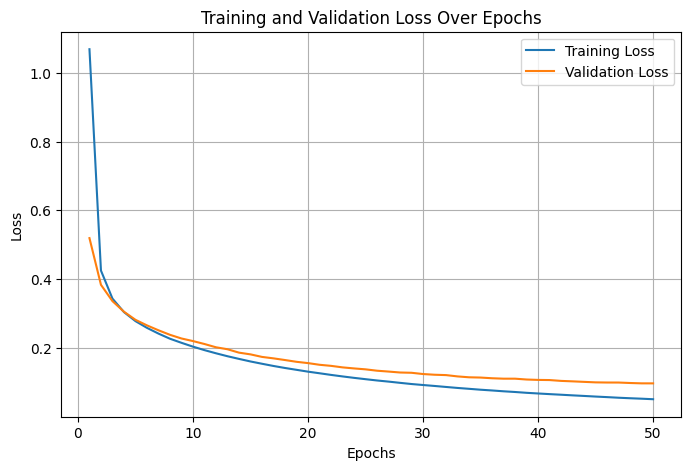

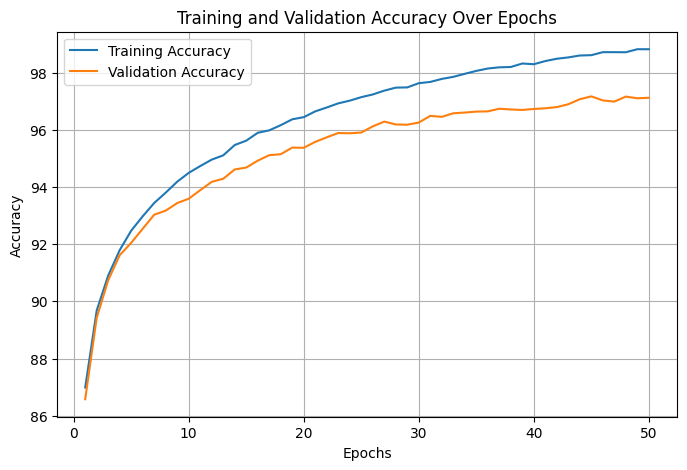

In [39]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

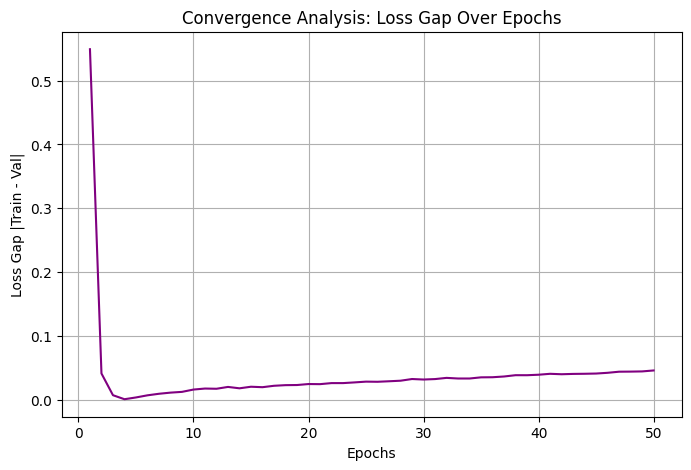

In [40]:
loss_gap = np.abs(np.array(train_losses) - np.array(val_losses))

plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss_gap, color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss Gap |Train - Val|')
plt.title('Convergence Analysis: Loss Gap Over Epochs')
plt.grid(True)
plt.show()